#**Bước 1:** Cài đặt các thư viện cần thiết

In [1]:
!pip install matplotlib==3.1.3
!pip install osmnet
!pip install folium

!pip install rtree
!pip install pygeos
!pip install geojson
!pip install geopandas
!pip install selenium

!apt-get update 
!apt install chromium-chromedriver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
selenium 4.5.0 requires urllib3[socks]~=1.26, but you have urllib3 1.25.11 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking i

In [2]:
import geopandas as gpd
import pandas as pd
import folium
import matplotlib.pyplot as plt
import osmnet
import rtree
import random
import numpy as np
from geopandas.tools import sjoin
from sklearn.cluster import KMeans
from folium import plugins
from selenium import webdriver
from folium.folium import time
import os
from PIL import Image

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
%cd '/content/drive/MyDrive/GIS'

/content/drive/MyDrive/GIS


#**Bước 2:** Clone data

In [4]:
!git clone https://github.com/CityScope/CSL_HCMC

fatal: destination path 'CSL_HCMC' already exists and is not an empty directory.


#**Bước 3:** Load ranh giới quận huyện và dân số quận huyện

In [5]:
path = "CSL_HCMC/Data/GIS/Population/population_HCMC/population_shapefile/Population_District_Level.shp"
data = gpd.read_file(path)
data = data.to_crs(4326)
data.head()

,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,...,Den_2012,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,geometry
0,District 1,760,District,180225.0,187435.0,187419.0,190943.0,197421.0,200297.0,193632.0,...,24749.60,25589.30,25962.10,25098.20,27022.1,27377.90,18486.8,15274.835115,7.714899e+06,"POLYGON ((106.69160 10.79553, 106.69181 10.795..."
1,District 3,770,District,190553.0,188945.0,190631.0,191580.0,193206.0,193694.0,196333.0,...,38897.10,39227.20,39326.30,39862.10,40221.7,40422.90,38652.5,12182.058264,4.925215e+06,"POLYGON ((106.68641 10.79229, 106.68667 10.792..."
2,District 4,773,District,180980.0,183261.0,184711.0,185649.0,185808.0,187157.0,186727.0,...,44428.40,44466.50,44789.30,44686.40,44750.6,44008.40,41958.7,9483.716891,4.178668e+06,"POLYGON ((106.71584 10.75245, 106.71574 10.752..."
3,District 6,775,District,249329.0,253474.0,254212.0,257865.0,266121.0,257183.0,258945.0,...,36105.70,37261.60,36010.20,36256.90,36508.5,36790.60,32702.7,13077.365262,7.140945e+06,"POLYGON ((106.64179 10.73826, 106.63760 10.735..."
4,District 7,778,District,244276.0,274828.0,268483.0,266633.0,280743.0,296757.0,310178.0,...,7563.59,7963.85,8418.12,8798.84,9006.2,9282.35,10216.5,33260.915360,3.525220e+07,"POLYGON ((106.75137 10.76062, 106.75001 10.758..."


#**Bước 4:** Load dữ liệu click của người dùng

In [6]:
path = "click_data.json/click_data.json"
click_data = gpd.read_file(path)
click_data = click_data.to_crs(4326) 
click_data.head()

,dbh,geometry
0,1,POINT (106.71136 10.85113)
1,1,POINT (106.71695 10.74449)
2,1,POINT (106.66315 10.83289)
3,1,POINT (106.66267 10.83339)
4,1,POINT (106.65977 10.83729)


In [7]:
click_data['point']=click_data['geometry']
click_data.head()

,dbh,geometry,point
0,1,POINT (106.71136 10.85113),POINT (106.71136 10.85113)
1,1,POINT (106.71695 10.74449),POINT (106.71695 10.74449)
2,1,POINT (106.66315 10.83289),POINT (106.66315 10.83289)
3,1,POINT (106.66267 10.83339),POINT (106.66267 10.83339)
4,1,POINT (106.65977 10.83729),POINT (106.65977 10.83729)


#**Bước 5:** Lọc ra 5 quận huyện có tốc độ tăng mật độ dân số nhanh nhất (2019->2017)

In [8]:
data["Den_Growth"] = data["Den_2019"] / data["Den_2017"] - 1
top5_data = data.nlargest(5, "Den_Growth")
top5_data

,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,...,Den_2013,Den_2014,Den_2015,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,geometry,Den_Growth
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,...,2489.70,2494.23,2543.50,2592.32,2719.58,3474.59,53139.220230,1.142649e+08,"POLYGON ((106.84015 10.89893, 106.84048 10.897...",0.277620
23,Hoc Mon,784,District,349065.0,358640.0,366502.0,396763.0,408683.0,414795.0,422471.0,...,3743.18,3799.16,3869.46,3977.58,4085.48,4966.47,65955.793966,1.091744e+08,"POLYGON ((106.58361 10.92869, 106.58391 10.928...",0.215639
18,Nha Be,786,District,101074.0,103793.0,110958.0,119416.0,126062.0,132034.0,139225.0,...,1254.48,1313.90,1385.46,1552.41,1771.22,2058.29,67540.905029,1.004901e+08,"POLYGON ((106.72315 10.72162, 106.72428 10.721...",0.162075
22,District 12,761,District,405360.0,427083.0,455881.0,475824.0,489511.0,499569.0,510326.0,...,9275.44,9466.02,9669.85,9968.06,10403.90,11750.80,47703.394094,5.277342e+07,"POLYGON ((106.69433 10.89842, 106.69446 10.897...",0.129461
17,District 2,769,District,147490.0,140621.0,137749.0,134131.0,140436.0,140288.0,147168.0,...,2812.21,2809.25,2947.02,3080.46,3243.16,3609.98,39592.970451,4.993869e+07,"POLYGON ((106.74241 10.80855, 106.74442 10.808...",0.113106


In [9]:
map = folium.Map(location=[10.775556, 106.701944], zoom_start=10, tiles='CartoDB positron')
for _, r in top5_data.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': "#" + "%06x" % random.randint(0, 0xFFFFFF)})
    folium.Popup(r['Dist_Name']).add_to(geo_j)
    geo_j.add_to(map)
map

#**Bước 6:** Dùng spatial join để lọc ra các điểm click của người dùng trong 5 quận/huyện hot nhất

In [10]:
top5_click = sjoin(top5_data, click_data)
top5_click.head()

,Dist_Name,Dist_ID,Level,Pop_2009,Pop_2010,Pop_2011,Pop_2012,Pop_2013,Pop_2014,Pop_2015,...,Den_2016,Den_2017,Den_2019,Shape_Leng,Shape_Area,geometry,Den_Growth,index_right,dbh,point
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,...,2592.32,2719.58,3474.59,53139.22023,1.142649e+08,"POLYGON ((106.84015 10.89893, 106.84048 10.897...",0.27762,51299,1,POINT (106.81247 10.78171)
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,...,2592.32,2719.58,3474.59,53139.22023,1.142649e+08,"POLYGON ((106.84015 10.89893, 106.84048 10.897...",0.27762,1316,1,POINT (106.81852 10.78415)
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,...,2592.32,2719.58,3474.59,53139.22023,1.142649e+08,"POLYGON ((106.84015 10.89893, 106.84048 10.897...",0.27762,66828,1,POINT (106.81852 10.78415)
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,...,2592.32,2719.58,3474.59,53139.22023,1.142649e+08,"POLYGON ((106.84015 10.89893, 106.84048 10.897...",0.27762,21131,1,POINT (106.81816 10.78439)
16,District 9,763,District,256257.0,263486.0,271537.0,276432.0,284473.0,284990.0,290620.0,...,2592.32,2719.58,3474.59,53139.22023,1.142649e+08,"POLYGON ((106.84015 10.89893, 106.84048 10.897...",0.27762,429,1,POINT (106.79251 10.78538)


#**Bước 7:** Chạy KMean cho top 5 quận huyện này. Lấy K = 20

In [11]:
mixs = []
for dist in top5_data.Dist_Name:
    kmean = KMeans(n_clusters=20, random_state=0)
    dist_point = np.c_[top5_click[top5_click.Dist_Name==dist].point.y, top5_click[top5_click.Dist_Name==dist].point.x]
    kmean.fit(dist_point)
    mixs.append((dist_point, kmean))

#**Bước 8:** Lưu 01 cụm điểm nhiều nhất trong các quận huyện ở Bước 5.

In [12]:
clusters = []
for dist_point, kmean in mixs:
    label = kmean.labels_.tolist()
    labelmaxodist=max(label,key=label.count)
    clusters.append(dist_point[kmean.labels_ == labelmaxodist])

#**Bước 9:** Show lên bản đồ các cụm đông nhất theo từng quận huyện theo dạng HEATMAP

In [13]:
for cluster in clusters:
    plugins.HeatMap(cluster).add_to(map)
map

#**Bước 10:** Lưu heatmap xuống file png

In [14]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: use options instead of chrome_options
  """


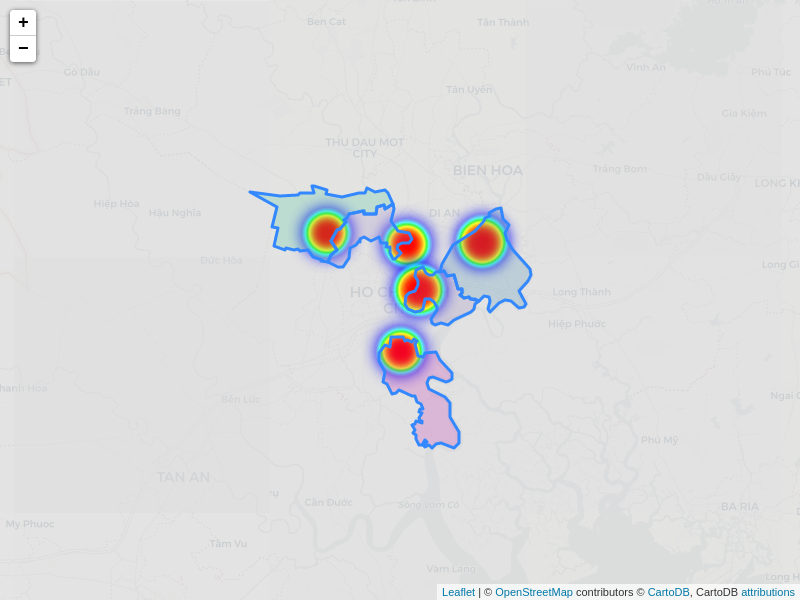

In [15]:
map_path='map.html'
map.save(map_path)

map_URL='file://{path}/{mapfile}'.format(path=os.getcwd(), mapfile=map_path)
driver.get(map_URL)
driver.save_screenshot('map.png')
driver.quit()

image = Image.open('map.png')
image